# Recap: What we have been doing


`1-Tensors-in-PyTorch.ipynb:` introduces a tensor representation in PyTorch

`2-Neural-networks-in-PyTorch.ipynb:` introduces a basic framework for defining neural networks via the `nn` module

`3-Training-neural-networks.ipynb:` introduces loss and backprop to improve predictions

`4-Fashion-MNIST.ipynb:` walks through the feed-forward neural network on Fashion MNIST data

# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We can avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, we'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [76]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import helper
import matplotlib.pyplot as plt

In [2]:
# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [78]:
# The same network as in Part 4
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # Define ReLU activation and log-softmax output 
        self.ReLU = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Flatten the images
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x
    
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (ReLU): ReLU()
  (logsoftmax): LogSoftmax()
)

The goal of the validation process is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [79]:
image, labels = next(iter(testloader))
probabilities = torch.exp(model(image))

In [80]:
# We expect probabilities to have shape [64, 10] - 10 for each class
probabilities.shape

torch.Size([64, 10])

In terms of accuracy, we can get the most likely class using the `probabilities.topk` method. This returns the $k$ highest values. If we want to get the most likely class, we can use `probabilities.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [81]:
# top_p is the probability value for the most likely class and top_class is an index for the most likely class
top_p, top_class = probabilities.topk(1, dim = 1)
# Look at the most likely classes for the first 10 examples:
top_class[0:10, :]

tensor([[4],
        [2],
        [2],
        [2],
        [4],
        [2],
        [4],
        [4],
        [8],
        [4]])

Now we can check whether predicted classes agree with labels. We can compare them by equating `top_class` with `labels` but we have to be careful with shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [82]:
equals = top_class == labels
print(equals.shape)

torch.Size([64, 64])


Therefore, we have to resize `labels` into a 2D tensor with shape `(64, 1)`:

In [83]:
equals = top_class == labels.view(*top_class.shape)

In [84]:
equals.shape

torch.Size([64, 1])

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [85]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(accuracy)
type(accuracy)

tensor(0.1562)


torch.Tensor

In [87]:
accuracy.item()

0.15625

In [88]:
print("Accuracy is " + str(accuracy.item()))

Accuracy is 0.15625


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but it is better to type it because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [89]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# without the validation accuracy:
epochs = 4
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        # Training pass
        optimizer.zero_grad()
        # Forward pass, get our log-probabilities
        log_prob = model.forward(images)
        loss = criterion(log_prob, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Training loss for epoch # " + str(e) + ": " + str(running_loss/len(trainloader)))

Training loss for epoch # 0: 0.5659778984402543
Training loss for epoch # 1: 0.3925558497974359
Training loss for epoch # 2: 0.3509288884079787
Training loss for epoch # 3: 0.32686208321977017


In [118]:
# with the validation accuracy:    
model = Network()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


train_losses, test_losses = [], []
epochs = 30
for e in range(epochs):
    running_train_loss = 0
    for images, labels in trainloader:

        # Training pass
        optimizer.zero_grad()
        # Forward pass, get our log-probabilities
        log_prob = model.forward(images)
        loss = criterion(log_prob, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    else:
        accuracy = 0
        running_test_loss = 0
        with torch.no_grad():
            for images, labels in testloader:
                log_probabilities = model(images)
                # Summing the loss
                running_test_loss += criterion(log_probabilities, labels)
                probabilities = torch.exp(log_probabilities)
                _, top_class = probabilities.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(running_train_loss/len(trainloader))
        test_losses.append(running_test_loss/len(testloader))
        print("Epoch # " + str(e) + ": train loss: " + str(running_train_loss/len(trainloader)) + ", test loss: " +
             str((running_test_loss/len(testloader)).item()) + ", test accuracy: " + str(accuracy))
        #print(train_losses)    
        #print(test_losses)


Epoch # 0: train loss: 0.5549325995576153, test loss: 0.4392203986644745, test accuracy: 0.75
Epoch # 1: train loss: 0.39259359388272647, test loss: 0.418307363986969, test accuracy: 0.8125
Epoch # 2: train loss: 0.34943972883035124, test loss: 0.3827912509441376, test accuracy: 0.9375
Epoch # 3: train loss: 0.3253372153287122, test loss: 0.3673012852668762, test accuracy: 0.8125
Epoch # 4: train loss: 0.3058837742360035, test loss: 0.37361595034599304, test accuracy: 0.875
Epoch # 5: train loss: 0.29127131190413097, test loss: 0.3349951505661011, test accuracy: 1.0
Epoch # 6: train loss: 0.27806474987282426, test loss: 0.3442407250404358, test accuracy: 0.8125
Epoch # 7: train loss: 0.2675480517163587, test loss: 0.35427266359329224, test accuracy: 0.75
Epoch # 8: train loss: 0.2555154951523616, test loss: 0.3414994478225708, test accuracy: 0.875
Epoch # 9: train loss: 0.249544369799496, test loss: 0.32582783699035645, test accuracy: 0.9375
Epoch # 10: train loss: 0.24006201420575063,

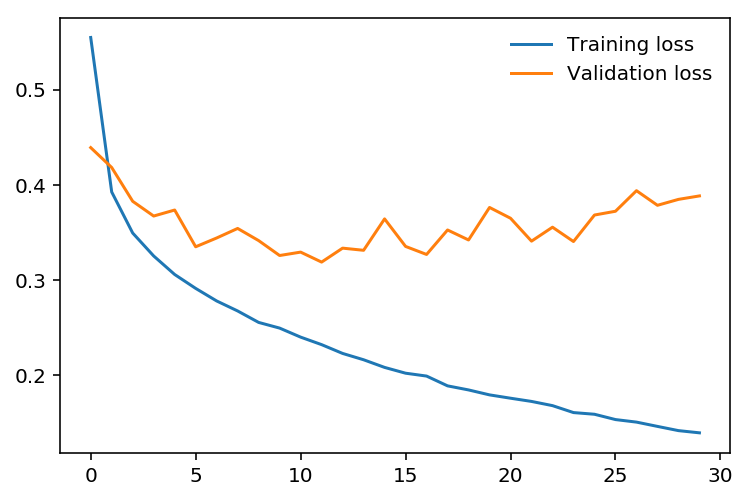

In [119]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

If we look at the plot above, we see a phenomenon called **overfitting**.

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to increasing validation loss. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you would save the model frequently as you're training then later choose the model with the lowest validation loss.

## Dropout and over-fitting

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop weights. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module. `nn.Dropout` uses drop probability as argument, which represents the fraction of weights to be dropped. 

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout: fully-connected >> ReLU >> dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output layer without dropout 
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

Typically, we don't use dropout in the last layer. Also, we only use dropout during training. During validation when we are making predictions, we want to have all of our weights available. Therefore, we need to turn off the dropout during validation, testing, and whenever we are making predictions. This is achieved by declaring `model.eval()`. This sets the model to the evaluation model where the dropout probability is 0.

You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.


In [121]:
class Network_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Flatten the images
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x
    
model = Network_dropout()
model

Network_dropout(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (ReLU): ReLU()
  (dropout): Dropout(p=0.2)
  (logsoftmax): LogSoftmax()
)

In [122]:
# with dropout:    
model = Network_dropout()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


train_losses, test_losses = [], []
epochs = 30
for e in range(epochs):
    running_train_loss = 0
    for images, labels in trainloader:

        # Training pass
        optimizer.zero_grad()
        # Forward pass, get our log-probabilities
        log_prob = model.forward(images)
        loss = criterion(log_prob, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    else:
        accuracy = 0
        running_test_loss = 0
        with torch.no_grad():
            # turn off the dropout
            model.eval()
            for images, labels in testloader:
                log_probabilities = model(images)
                # Summing the loss
                running_test_loss += criterion(log_probabilities, labels)
                probabilities = torch.exp(log_probabilities)
                _, top_class = probabilities.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        # turn on the dropout again        
        model.train()        
        train_losses.append(running_train_loss/len(trainloader))
        test_losses.append(running_test_loss/len(testloader))
        print("Epoch # " + str(e) + ": train loss: " + str(running_train_loss/len(trainloader)) + ", test loss: " +
             str((running_test_loss/len(testloader)).item()) + ", test accuracy: " + str(accuracy))
        #print(train_losses)    
        #print(test_losses)

Epoch # 0: train loss: 0.6305651643128791, test loss: 0.45241600275039673, test accuracy: 0.8125
Epoch # 1: train loss: 0.43071292259736355, test loss: 0.4091639518737793, test accuracy: 0.8125
Epoch # 2: train loss: 0.39341905110998193, test loss: 0.39532381296157837, test accuracy: 1.0
Epoch # 3: train loss: 0.3691373895734612, test loss: 0.37137719988822937, test accuracy: 0.9375
Epoch # 4: train loss: 0.35149892823083567, test loss: 0.35996413230895996, test accuracy: 1.0
Epoch # 5: train loss: 0.3400023985646173, test loss: 0.354417622089386, test accuracy: 0.9375
Epoch # 6: train loss: 0.33018318564494026, test loss: 0.34267446398735046, test accuracy: 0.875
Epoch # 7: train loss: 0.3196115864714834, test loss: 0.3389335870742798, test accuracy: 0.9375
Epoch # 8: train loss: 0.3122832314895668, test loss: 0.34221184253692627, test accuracy: 0.8125
Epoch # 9: train loss: 0.30620435178915323, test loss: 0.3355485498905182, test accuracy: 0.875
Epoch # 10: train loss: 0.300178551820

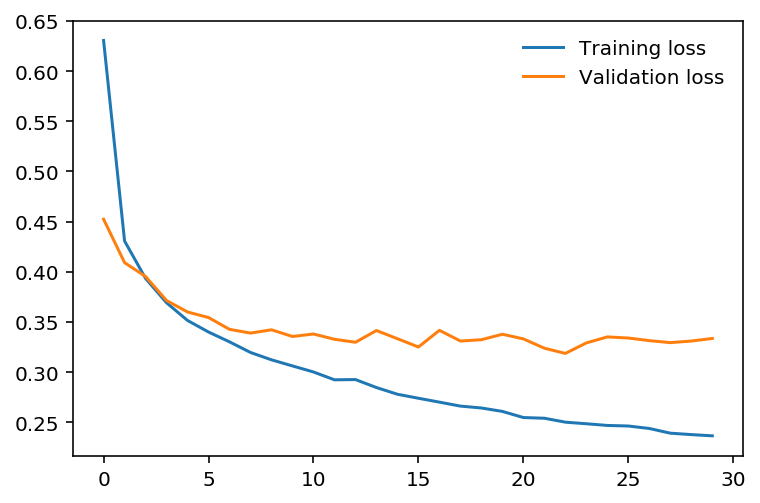

In [123]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

That looks a bit better. We can add more layers to achieve a little bit lower loss.

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

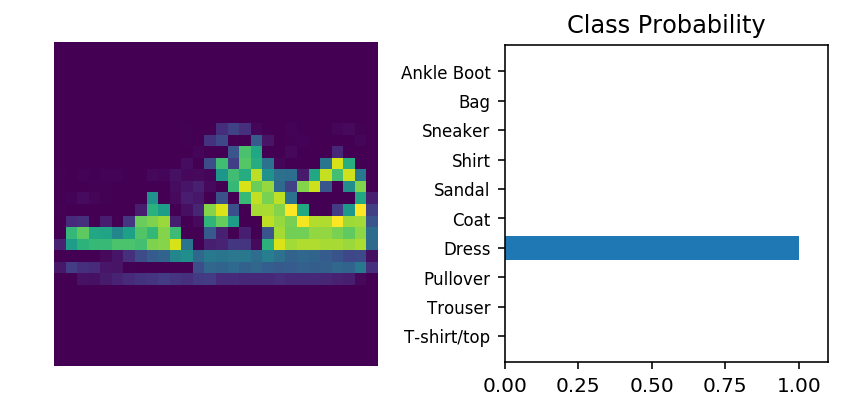

In [130]:
model.eval()
images, labels = iter(testloader).next()
# Select a random image
rand_sample = 8
img = images[rand_sample]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    log_probabilities = model.forward(img)

probabilities = torch.exp(log_probabilities)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [126]:
dataiter

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.